# 注意力机制

在“编码器—解码器（seq2seq）”⼀节⾥，解码器在各个时间步依赖相同的背景变量（context vector）来获取输⼊序列信息。当编码器为循环神经⽹络时，背景变量来⾃它最终时间步的隐藏状态。将源序列输入信息以循环单位状态编码，然后将其传递给解码器以生成目标序列。然而这种结构存在着问题，尤其是RNN机制实际中存在长程梯度消失的问题，对于较长的句子，我们很难寄希望于将输入的序列转化为定长的向量而保存所有的有效信息，所以随着所需翻译句子的长度的增加，这种结构的效果会显著下降。

与此同时，解码的目标词语可能只与原输入的部分词语有关，而并不是与所有的输入有关。例如，当把“Hello world”翻译成“Bonjour le monde”时，“Hello”映射成“Bonjour”，“world”映射成“monde”。在seq2seq模型中，解码器只能隐式地从编码器的最终状态中选择相应的信息。然而，注意力机制可以将这种选择过程显式地建模。


![avatar][base64str1]





[base64str1]: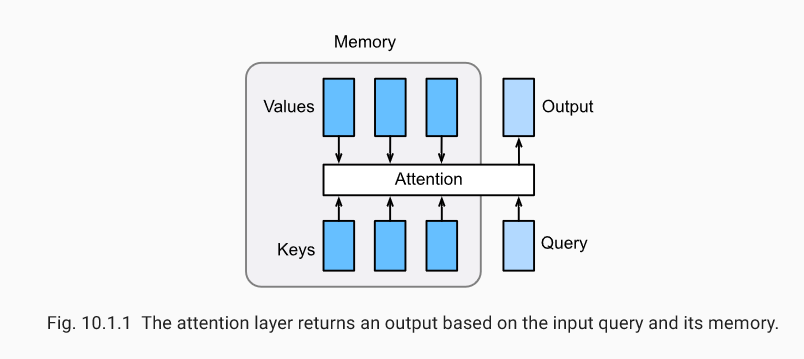

## 注意力机制框架

Attention 是一种通用的带权池化方法，输入由两部分构成：询问（query）和键值对（key-value pairs）。$𝐤_𝑖∈ℝ^{𝑑_𝑘}, 𝐯_𝑖∈ℝ^{𝑑_𝑣}$. Query  $𝐪∈ℝ^{𝑑_𝑞}$ , attention layer得到输出与value的维度一致 $𝐨∈ℝ^{𝑑_𝑣}$. 对于一个query来说，attention layer 会与每一个key计算注意力分数并进行权重的归一化，输出的向量$o$则是value的加权求和，而每个key计算的权重与value一一对应。

为了计算输出，我们首先假设有一个函数$\alpha$ 用于计算query和key的相似性，然后可以计算所有的 attention scores $a_1, \ldots, a_n$ by


$$
a_i = \alpha(\mathbf q, \mathbf k_i).
$$


我们使用 softmax函数 获得注意力权重：


$$
b_1, \ldots, b_n = \textrm{softmax}(a_1, \ldots, a_n).
$$


最终的输出就是value的加权求和：


$$
\mathbf o = \sum_{i=1}^n b_i \mathbf v_i.
$$


![avatar][base64str2]

不同的attetion layer的区别在于score函数的选择，在本节的其余部分，我们将讨论两个常用的注意层 Dot-product Attention 和 Multilayer Perceptron Attention；随后我们将实现一个引入attention的seq2seq模型并在英法翻译语料上进行训练与测试。

[base64str2]: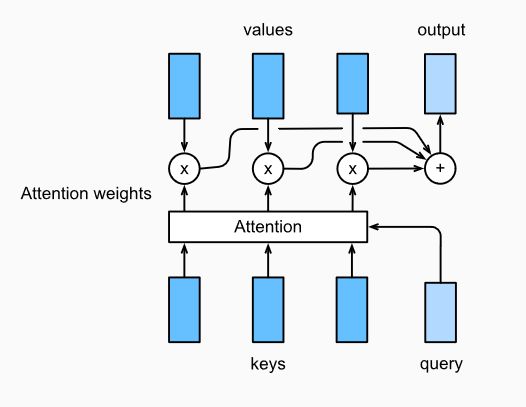

In [1]:
import math
import torch
import torch.nn as nn

In [4]:
import os
def file_name_walk(file_dir):
    for root, dirs, files in os.walk(file_dir):
        #print("root", root)  # 当前目录路径
        print("dirs", dirs)   #当前目录下所有子目录
        print("files", files) #当前路径下所有非目录子文件
        
file_name_walk(r'C:\000Disk\Learn\PyTorch\start_to_learn\data\input\fraeng6506')   

dirs []
files ['fra.txt', '_about.txt']


-------------------------------------------------------
## softmax屏蔽

在深入研究实现之前,我们首先介绍softmax操作符的一个屏蔽操作

### 为什么要屏蔽？

In [54]:
def SequenceMask(X, X_len, value=-1e6):
    print("\nX.size(1) is ------------\n", X.size(1))
    print("\nX_len is -----------------\n", X_len)
    print("\nX.len[:, None] is -----------------\n", X_len[:, None])
    maxlen = X.size(1)
    print("\ntorch.arange((maxlen),dtype=torch.float) is -----------\n", torch.arange((maxlen),dtype=torch.float))
    print("\ntorch.arange((maxlen),dtype=torch.float)[None, :] is -----------\n", torch.arange((maxlen),dtype=torch.float)[None, :])
    
    mask = torch.arange((maxlen),dtype=torch.float)[None, :] >= X_len[:, None]
    print("\nmask is --------------\n", mask)
    X[mask] =  value
    return X

In [56]:
def masked_softmax(X, valid_length):
    # X: 3-D tensor, valid length: 1-D or 2-D tensor
    print("X is -----------------------\n", X)
    print("\nX.shape is --------------------\n", X.shape)
    print("\nvalid_length is ------------\n", valid_length)
    softmax = nn.Softmax(dim=-1)
    if valid_length is None:
        return softmax(X)
    else:
        shape = X.shape
        print("\nshape is -----------------\n",shape)
        print("\nvalid_length.dim() is ------------\n", valid_length.dim())
        print("\nvalid_length.numpy().repeat(shape[1],axis=0) is -------",
              valid_length.numpy().repeat(shape[1],axis=0))
        print("\nvalid_length.reshape((-1,)) is -------",
              valid_length.reshape((-1,)))
        if valid_length.dim() == 1:
            try:
                valid_length = torch.FloatTensor(valid_length.numpy().repeat(shape[1],axis=0))
            except:
                valid_length = torch.FloatTensor(valid_length.cpu().numpy().repeat(shape[1],axis=0))
        else:
            valid_length = valid_length.reshape((-1,))
        
        # fill masked elements with a large negative, whose exp is 0
        print("\nX.reshape((-1, shape[-1])) is ---------\n", X.reshape((-1, shape[-1])))
        X = SequenceMask(X.reshape((-1, shape[-1])), valid_length)
        print("\nX is -------------\n", X)
        print("\nX.shape is -------------\n",X.shape)
        return softmax(X).reshape(shape)
    

masked_softmax(torch.rand((2,2,4),dtype=torch.float), torch.FloatTensor([2,3]))

X is -----------------------
 tensor([[[0.9870, 0.9354, 0.7227, 0.3492],
         [0.1814, 0.6032, 0.4202, 0.2519]],

        [[0.1840, 0.2636, 0.7671, 0.2387],
         [0.1975, 0.2041, 0.7224, 0.4346]]])

X.shape is --------------------
 torch.Size([2, 2, 4])

valid_length is ------------
 tensor([2., 3.])

shape is -----------------
 torch.Size([2, 2, 4])

valid_length.dim() is ------------
 1

valid_length.numpy().repeat(shape[1],axis=0) is ------- [2. 2. 3. 3.]

valid_length.reshape((-1,)) is ------- tensor([2., 3.])

X.reshape((-1, shape[-1])) is ---------
 tensor([[0.9870, 0.9354, 0.7227, 0.3492],
        [0.1814, 0.6032, 0.4202, 0.2519],
        [0.1840, 0.2636, 0.7671, 0.2387],
        [0.1975, 0.2041, 0.7224, 0.4346]])

X.size(1) is ------------
 4

X_len is -----------------
 tensor([2., 2., 3., 3.])

X.len[:, None] is -----------------
 tensor([[2.],
        [2.],
        [3.],
        [3.]])

torch.arange((maxlen),dtype=torch.float) is -----------
 tensor([0., 1., 2., 3.])

tensor([[[0.5129, 0.4871, 0.0000, 0.0000],
         [0.3961, 0.6039, 0.0000, 0.0000]],

        [[0.2581, 0.2795, 0.4624, 0.0000],
         [0.2705, 0.2723, 0.4572, 0.0000]]])

In [49]:
masked_softmax(torch.rand((2,2,4),dtype=torch.float), torch.FloatTensor([[2,3],[1,2]]))

X is -----------------------
 tensor([[[0.2775, 0.9680, 0.5301, 0.8798],
         [0.3498, 0.5964, 0.5706, 0.8933]],

        [[0.6290, 0.8170, 0.3843, 0.8679],
         [0.7261, 0.2510, 0.7167, 0.7678]]])

X.shape is --------------------
 torch.Size([2, 2, 4])

valid_length is ------------
 tensor([[2., 3.],
        [1., 2.]])

shape is -----------------
 torch.Size([2, 2, 4])

valid_length.dim() is ------------
 2

valid_length.numpy().repeat(shape[1],axis=0) is ------- [[2. 3.]
 [2. 3.]
 [1. 2.]
 [1. 2.]]

valid_length.reshape((-1,)) is ------- tensor([2., 3., 1., 2.])

X.reshape((-1, shape[-1])) is ---------
 tensor([[0.2775, 0.9680, 0.5301, 0.8798],
        [0.3498, 0.5964, 0.5706, 0.8933],
        [0.6290, 0.8170, 0.3843, 0.8679],
        [0.7261, 0.2510, 0.7167, 0.7678]])

X.shape is -------------
 torch.Size([4, 4])


tensor([[[0.3339, 0.6661, 0.0000, 0.0000],
         [0.2835, 0.3629, 0.3536, 0.0000]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.6166, 0.3834, 0.0000, 0.0000]]])

**超出2维矩阵的乘法** 

$X$ 和 $Y$ 是维度分别为$(b,n,m)$ 和$(b, m, k)$的张量，进行 $b$ 次二维矩阵乘法后得到 $Z$, 维度为 $(b, n, k)$。


$$
 Z[i,:,:] = dot(X[i,:,:], Y[i,:,:])\qquad for\ i= 1,…,n\ .
$$


In [58]:
torch.bmm(torch.ones((2,1,3), dtype = torch.float), torch.ones((2,3,2), dtype = torch.float))

tensor([[[3., 3.]],

        [[3., 3.]]])

# 点积注意力
The dot product 假设query和keys有相同的维度, 即 $\forall i, 𝐪,𝐤_𝑖 ∈ ℝ_𝑑 $. 通过计算query和key转置的乘积来计算attention score,通常还会除去 $\sqrt{d}$ 减少计算出来的score对维度𝑑的依赖性，如下


$$
𝛼(𝐪,𝐤)=⟨𝐪,𝐤⟩/ \sqrt{d} 
$$

假设 $ 𝐐∈ℝ^{𝑚×𝑑}$ 有 $m$ 个query，$𝐊∈ℝ^{𝑛×𝑑}$ 有 $n$ 个keys. 我们可以通过矩阵运算的方式计算所有 $mn$ 个score：


$$
𝛼(𝐐,𝐊)=𝐐𝐊^𝑇/\sqrt{d}
$$
 
现在让我们实现这个层，它支持一批查询和键值对。此外，它支持作为正则化随机删除一些注意力权重.

# 习题
选择题

### 1.以下对于注意力机制叙述错误的是：

A.注意力机制借鉴了人类的注意力思维方式，以获得需要重点关注的目标区域。

B.在计算注意力权重时，key 和 query 对应的向量维度需相等。

C.点积注意力层不引入新的模型参数。

D.注意力掩码可以用来解决一组变长序列的编码问题。

**答案：B**
答案解释

在Dot-product Attention中，key与query维度需要一致，在MLP Attention中则不需要。

### 2.以下对于加入Attention机制的seq2seq模型的陈述正确的是：

A.seq2seq模型不可以生成无穷长的序列。

B.每个时间步，解码器输入的语境向量(context vector)相同

C.解码器RNN仍由编码器最后一个时间步的隐藏状态初始化。

D.引入注意力机制可以加速模型训练。
**答案：C**
答案解释

选项1：seq2seq模型的预测需人为设定终止条件，设定最长序列长度或者输出[EOS]结束符号，若不加以限制则可能生成无穷长度序列

选项2：不同，每个位置都会计算各自的attention输出

选项3：正确

选项4：注意力机制本身有高效的并行性，但引入注意力并不能改变seq2seq内部RNN的迭代机制，因此无法加速。

### 3.关于点积注意力机制描述错误的是：

A.高维张量的矩阵乘法可用于并行计算多个位置的注意力分数。

B.计算点积后除以$\sqrt{d}$以减轻向量维度对注意力权重的影响。

C.可视化注意力权重的二维矩阵有助于分析序列内部的依赖关系。

D.对于两个有效长度不同的输入序列，若两组键值对完全相同，那么对于同一个query的输出一定相同。

**答案：D**
答案解释

有效长度不同导致 Attention Mask 不同，屏蔽掉无效位置后进行attention，会导致不同的输出。参考代码Dot-Product Attention的测试部分。
